In [1]:
cd /g/data/jk72/deg581/vanom/ana/notebooks

/g/data/jk72/deg581/vanom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/130580362.gadi-pbs'

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

In [4]:
# Suite for Analysis - Overview

# script needs to:
# load 1-5 variables from multiple files
# run some calculation and concatenate together
# make some plots

In [5]:
grd = xr.open_dataset('/g/data/jk72/deg581/vanderford-setup/data/proc/vand_2km_v5_lb_grd.nc')


In [6]:


FilePath='/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/' # Truth file settings
prefix='roms_his_'
timeRange = [10,11]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux'])#,'AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

# plt.figure(figsize=(15,15))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [2.399e6,-904000],
    [2.4e6,-925000],
    [2.43e6,-905800],
    [2.43e6,-900000],
    [2.42e6,-887500],
    [2.4e6,-904000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])

ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'vanderford'
ds.mask_zice_roi.attrs['long_name']=roi_label1
# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_BM = ds

ds.close()

['/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0010.nc']
0.418906436 G
0.415037728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [7]:
ds_BM = ds_BM.drop_vars(['Tb','Sb','w'])
print(ds_BM.nbytes/1e9,'G')
ds_BM

0.463969556 G


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 25, s_w: 26,
                        eta_rho: 110, xi_rho: 61, xi_u: 60, eta_v: 109,
                        ocean_time: 73)
Coordinates: (12/15)
  * s_rho              (s_rho) float64 -0.98 -0.94 -0.9 ... -0.1 -0.06 -0.02
  * s_w                (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
    x_rho              (eta_rho, xi_rho) float64 2.379e+06 ... 2.499e+06
    y_rho              (eta_rho, xi_rho) float64 -9.39e+05 ... -7.21e+05
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    ...                 ...
    y_psi              (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
  * ocean_time         (ocean_time) datetime64[ns] 2016-01-04 ... 2016-12-29
    lon_rho            (eta_rho, xi_rho) float64 111.5 111.5 ... 106.1 106.1
    lat_rho            (eta_rho, xi_rho) float64 -66.77 -66.75 ... -66.41 -66.39
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(26, 110, 61), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(25, 110, 61), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/106)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    dy_v               (eta_v, xi_rho) float64 dask.array<chunksize=(109, 61), meta=np.ndarray>
    dy_psi             (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
    dA                 (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 61), meta=np.ndarray>
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
Attributes: (12/34)
    file:              roms_his_0010.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Vanderford Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            012x016
    history:           ROMS/TOMS, Version 4.1, Saturday - December 14, 2024 -...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       VANDERFORD, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL, ANA_S...

['/g/data/jk72/deg581/vanom/mdl/vanderford_v5_lb2/roms_his_0010.nc']
0.418906436 G
0.415037728 G


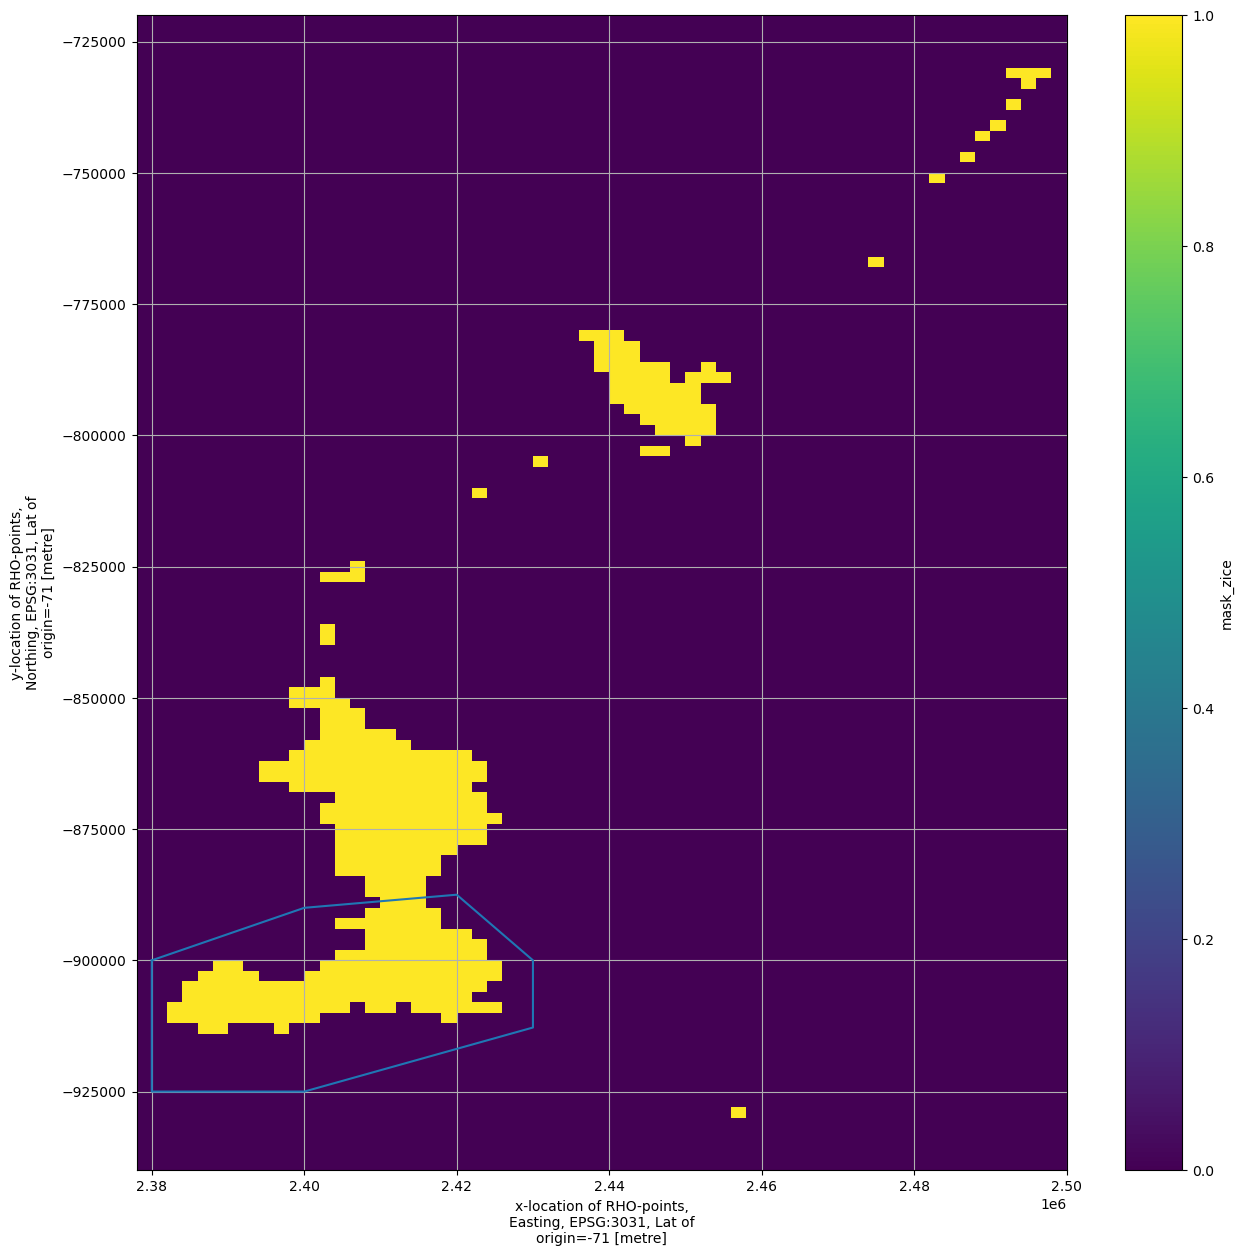

making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [8]:


FilePath='/g/data/jk72/deg581/vanom/mdl/vanderford_v5_lb2/' # Truth file settings
prefix='roms_his_'
timeRange = [10, 11]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

plt.figure(figsize=(15,15))
ds.mask_zice.plot(x='x_rho',y='y_rho')
plt.grid()
poly_shelf = np.array([
    [2.38e6,-900000],
    [2.38e6,-925000],
    [2.4e6,-925000],
    [2.43e6,-912800],
    [2.43e6,-900000],
    [2.42e6,-887500],
	[2.40e6,-890000],
    [2.38e6,-900000]])
plt.plot(poly_shelf[:,0],poly_shelf[:,1])
plt.show()


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])

ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'vanderford'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_LB = ds

ds.close()

In [9]:
ds_LB = ds_LB.drop_vars(['Tb','Sb','w'])
print(ds_LB.nbytes/1e9,'G')
ds_LB

0.463969556 G


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 25, s_w: 26,
                        eta_rho: 110, xi_rho: 61, xi_u: 60, eta_v: 109,
                        ocean_time: 73)
Coordinates: (12/15)
  * s_rho              (s_rho) float64 -0.98 -0.94 -0.9 ... -0.1 -0.06 -0.02
  * s_w                (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
    x_rho              (eta_rho, xi_rho) float64 2.379e+06 ... 2.499e+06
    y_rho              (eta_rho, xi_rho) float64 -9.39e+05 ... -7.21e+05
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    ...                 ...
    y_psi              (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
  * ocean_time         (ocean_time) datetime64[ns] 2016-01-04 ... 2016-12-29
    lon_rho            (eta_rho, xi_rho) float64 111.5 111.5 ... 106.1 106.1
    lat_rho            (eta_rho, xi_rho) float64 -66.77 -66.75 ... -66.41 -66.39
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(26, 110, 61), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(25, 110, 61), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/106)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    dy_v               (eta_v, xi_rho) float64 dask.array<chunksize=(109, 61), meta=np.ndarray>
    dy_psi             (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
    dA                 (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 61), meta=np.ndarray>
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
Attributes: (12/34)
    file:              roms_his_0010.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Vanderford Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            012x016
    history:           ROMS/TOMS, Version 4.1, Friday - December 13, 2024 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       VANDERFORD, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL, ANA_S...

# Make some mean plots

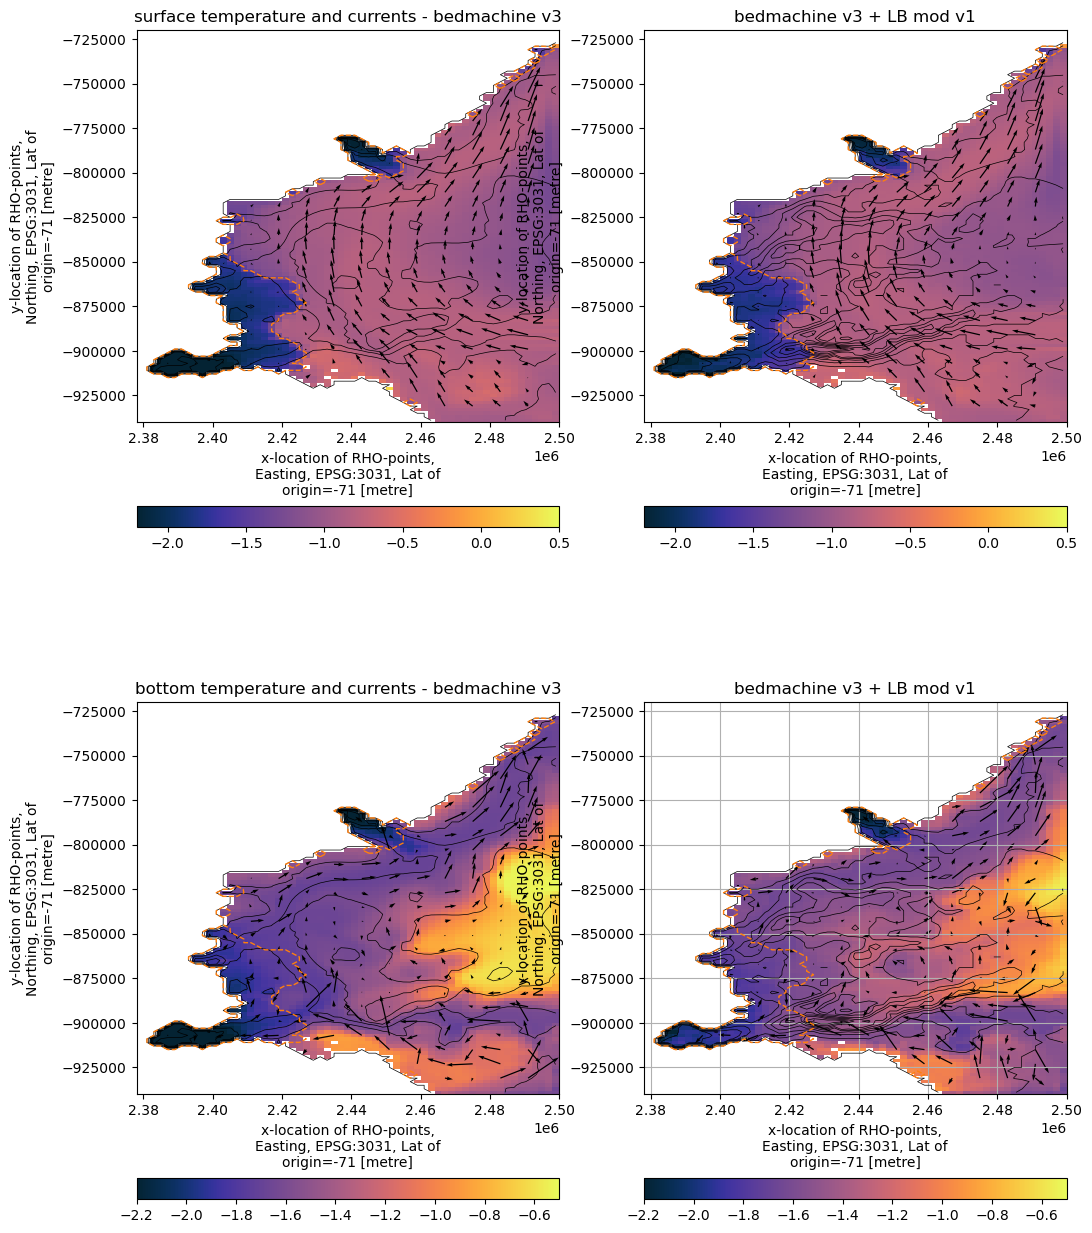

In [10]:
res=4

fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(12,16))
ax = axs[0,0]
im=(ds_BM.temp).isel(s_rho=-1).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=0.5)
(ds_BM.h*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_BM.zice*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_BM.u_rho.isel(s_rho=-1).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_BM.v_rho.isel(s_rho=-1).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('surface temperature and currents - bedmachine v3')
plt.grid()
ax = axs[0,1]
im=(ds_LB.temp).isel(s_rho=-1).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=0.5)
(ds_LB.h*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_LB.zice*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_LB.u_rho.isel(s_rho=-1).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_LB.v_rho.isel(s_rho=-1).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('bedmachine v3 + LB mod v1')
plt.grid()
ax = axs[1,0]
im=(ds_BM.temp).isel(s_rho=0).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=-0.5)
(ds_BM.h*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_BM.zice*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_BM.u_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_BM.v_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('bottom temperature and currents - bedmachine v3')
plt.grid()
ax = axs[1,1]
im=(ds_LB.temp).isel(s_rho=0).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=-0.5)
(ds_LB.h*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_LB.zice*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_LB.u_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_LB.v_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('bedmachine v3 + LB mod v1')
plt.grid()
plt.show()


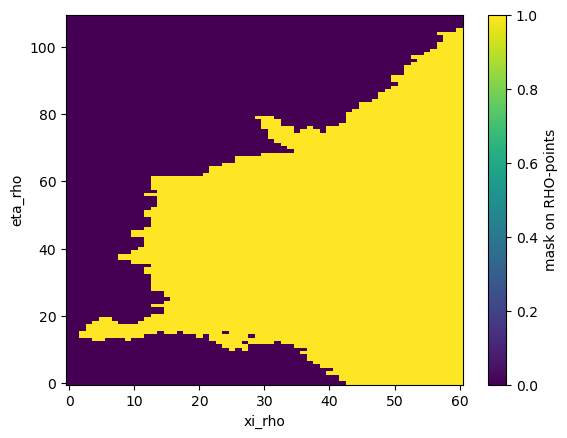

In [11]:
ds_BM.mask_rho.plot()


Text(0.5, 0.98, 'transect at -905000.0')

<Figure size 640x480 with 0 Axes>

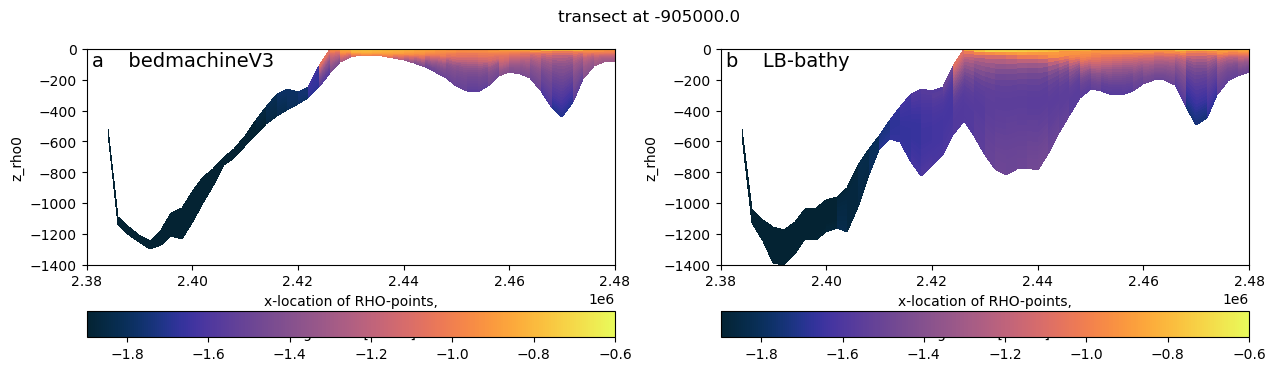

In [12]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,4])
ax = None

ax=fig.add_subplot(gs[0,0])

im=(ds_BM.temp).isel(eta_rho=17).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='z_rho0',cmap='cmo.thermal',add_colorbar=False,vmin=-1.9,vmax=-.6)

plt.colorbar(im,orientation='horizontal')
ax.text(0.01, 0.99, 'a    bedmachineV3', transform=ax.transAxes,fontsize=14, va='top')
ax.set_xlim((2.38e6,2.48e6))
ax.set_ylim((-1400,0))

ax=fig.add_subplot(gs[0,1])

im=(ds_LB.temp).isel(eta_rho=17).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='z_rho0',cmap='cmo.thermal',add_colorbar=False,vmin=-1.9,vmax=-.6)

plt.colorbar(im,orientation='horizontal')
ax.text(0.01, 0.99, 'b    LB-bathy', transform=ax.transAxes,fontsize=14, va='top')
ax.set_xlim((2.38e6,2.48e6))
ax.set_ylim((-1400,0))
plt.suptitle('transect at '+str((ds_LB.y_rho.isel(eta_rho=17,xi_rho=0).values.round(1))))

Text(0, 0.5, 'melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

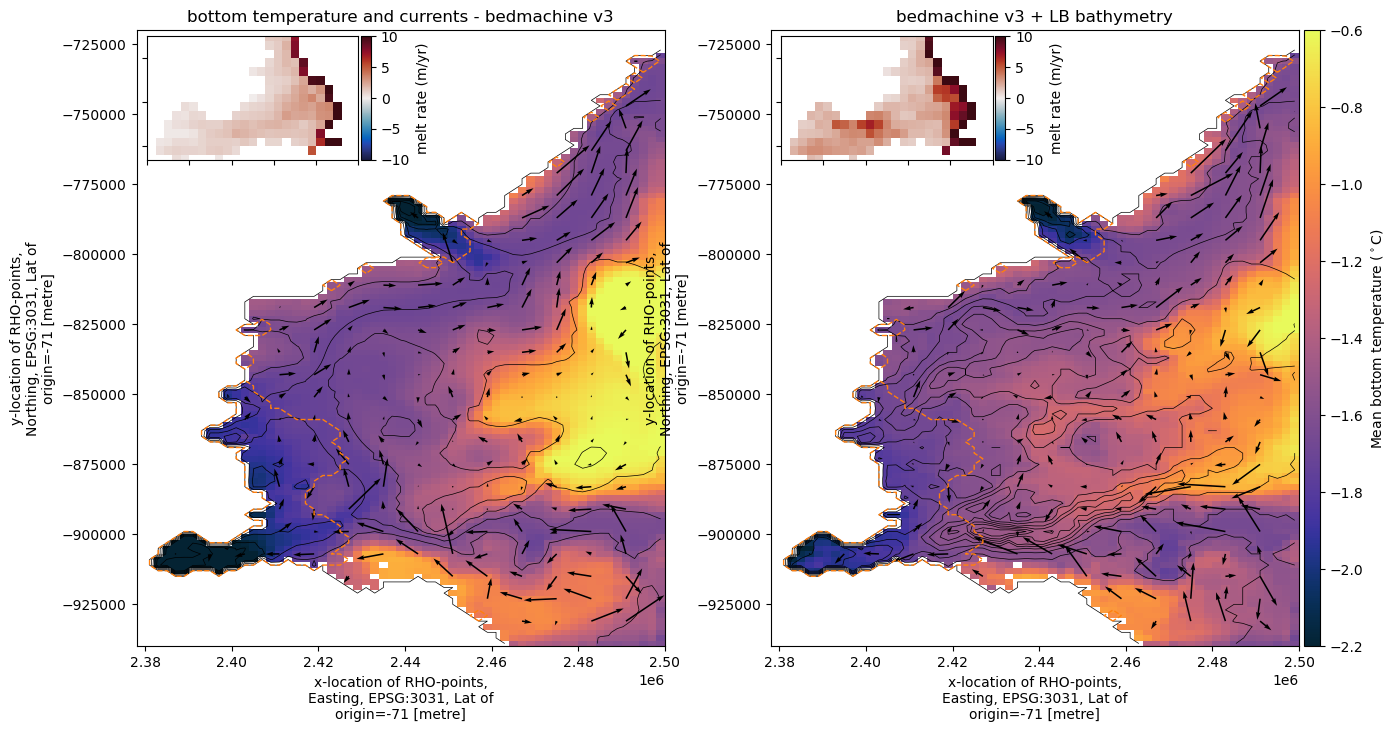

In [13]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,8])
ax = None

ax=fig.add_subplot(gs[0,0])
im=(ds_BM.temp).isel(s_rho=0).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=-.6)
(ds_BM.h*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_BM.zice*ds_BM.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
# plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_BM.u_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_BM.v_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('bottom temperature and currents - bedmachine v3')


ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="20%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.79, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
im1 = (ds_BM.mask_rho*(ds_BM.mask_ziceNaN)*ds_BM.my.mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-10,vmax=10)
ax.set_xlim((2.38e6,2.43e6))
ax.set_ylim((-.913e6,-0.885e6))

ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)


####################
ax=fig.add_subplot(gs[0,1])
im=(ds_LB.temp).isel(s_rho=0).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.2,vmax=-.6)
(ds_LB.h*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=np.arange(0,2500,250),colors='k',linewidths=0.5)
(ds_LB.zice*ds_LB.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[-1,0],colors='C1',linewidths=1)
# plt.colorbar(im,orientation='horizontal')
ax.quiver(ds.x_rho[0:-1:res,0:-1:res],ds.y_rho[0:-1:res,0:-1:res], ds_LB.u_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res], ds_LB.v_rho.isel(s_rho=0).mean(dim='ocean_time')[0:-1:res,0:-1:res],angles='uv')
ax.set_title('bedmachine v3 + LB bathymetry')
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom temperature ($^\circ$C)')


ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="20%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.79, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
im1 = (ds_LB.mask_rho*(ds_LB.mask_ziceNaN)*ds_LB.my.mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-10,vmax=10)
ax.set_xlim((2.38e6,2.43e6))
ax.set_ylim((-.913e6,-0.885e6))

ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)